In [64]:
import torch
import torch.nn.functional as F

In [65]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [66]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [67]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


At Initialisation, we recorded a loss of ~27 which is way to high meaning that model is confidently making wrong guesses.

Basically we want all the logits to be near to 0 which would in turn make all probabilites equal.

Equal probs means every character is likely the next character at initialsation

logits = h @ w2 + b2, since we want all logits to be near to zero we will not take bias as of now - > bias * 0

Also we will scale w2 by a number < 1

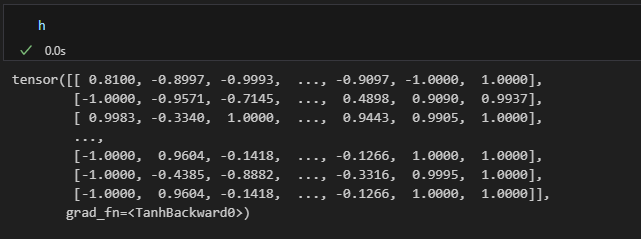

If we have a look at h, we see many of its values are close to 1.0 and -1.0

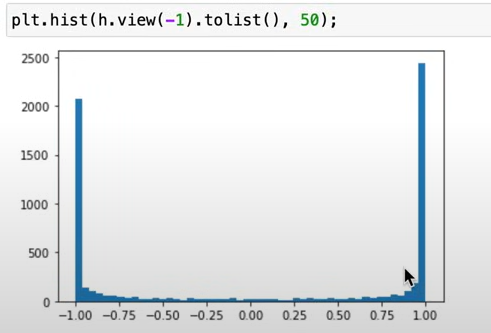

Distrubution of preactivations (hpreact)

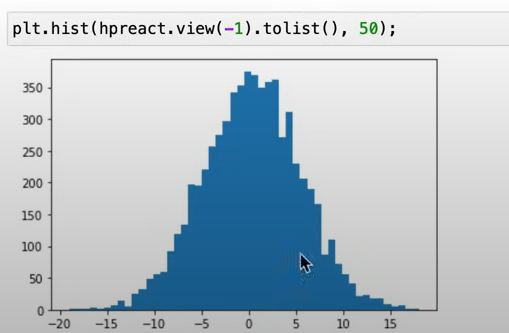

These values are h are very terrible because

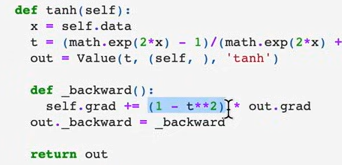

if the outputs of tanh are very close to 1 or -1, it is going to stop the flow ofn gradients while backpropogation

No matter what out.grad is, we are killing the gradient, and we are stopping backprop from this tanh unit

DEAD NUERON - No single example activates the neuron

To sort this issue, we will try to initialise hpreact near to 0

We want the output (h in our case) to be unit gaussion, mean = 0  and S.D = 1

Therefore, we should divide the W by the sqrt of the fan_in

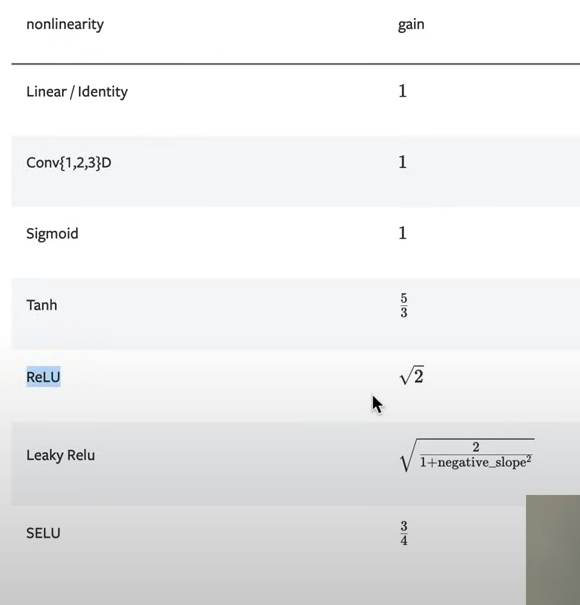

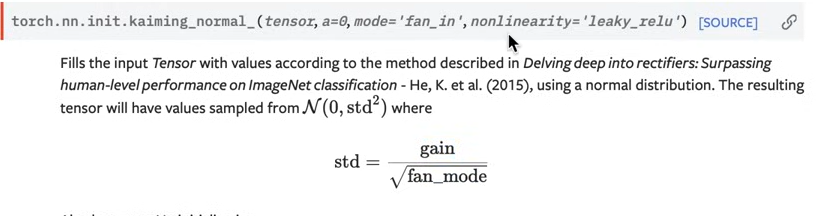

---------------------------------------------------------------------------------------------------------------------------------------------------

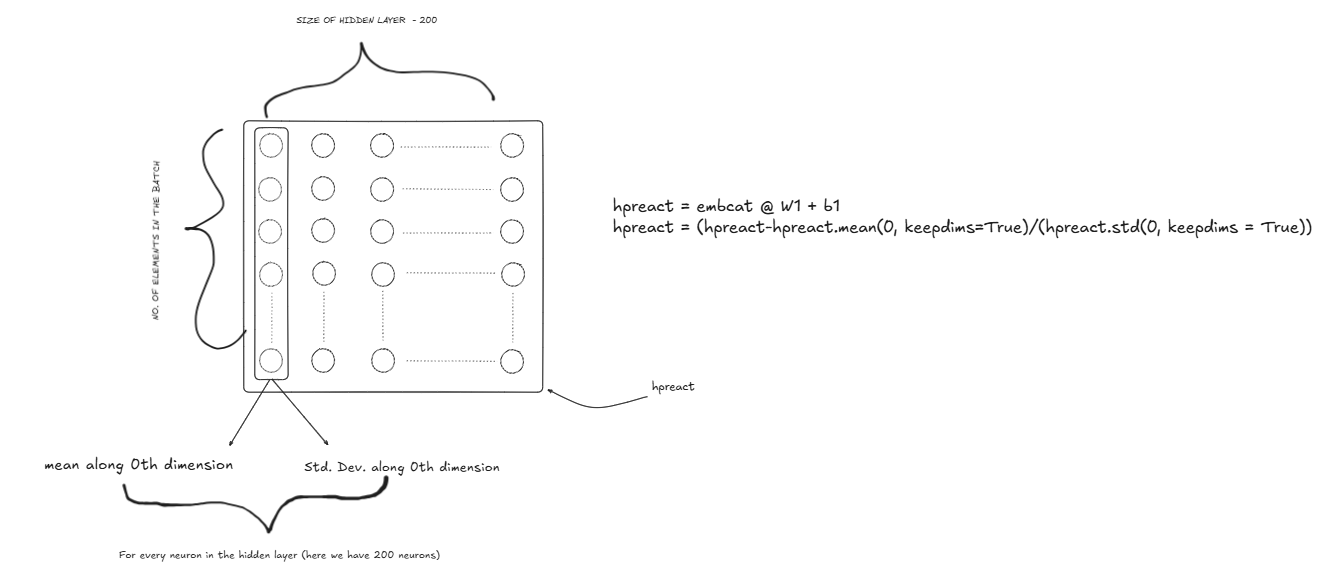

--------------------------------------------------------------------------------------------------------------------------------------------------

Only noramlising the pre-activations(hpreact) wont work, because we dont want them to be roughly gaussion always, we only want at initialisation

We want that they can move flexibly during run-time

To handle this, the concept of scale and shift is introduced.

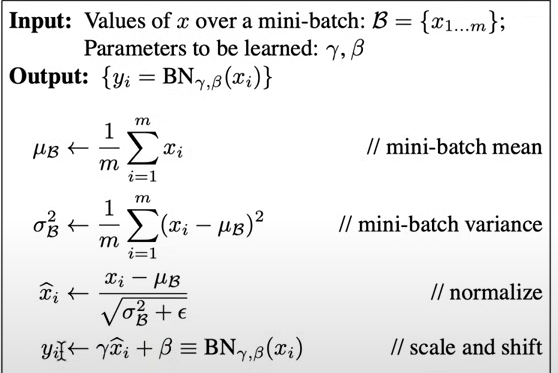

We initialise the gains by 1 and bias by 0

In [68]:
# MLP Revisited

n_emb = 14          # the dimensionality of thhe character embedding vectors
n_hidden = 200      # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size)**0.5) #0.2
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # Commenting because it is useless in case of batch normalisation
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1,b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of paramters in total 
for p in parameters:
    p.requires_grad = True

14605


In [69]:
# Same optimization as last time
max_steps = 200000
# batch_size = 32
batch_size = 48
lossi = []

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # Batch X, Y

    # Forward pass
    emb = C[Xb]  # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # Concatenate the vectors

    # Linear Layer
    hpreact = embcat @ W1 # + b1  # Hidden layer pre-activation, Commented because it is useless in case of batch normalisation

    # BatchNorm Layer
    #---------------------------------------------------------------------------------------------------
    """
    NOTE : We don't use the running mean and running standard deviation while training, we use bnmeai and bnstdi
    """

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        """
        Momentum = 0.001
        """

        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    #---------------------------------------------------------------------------------------------------


    # Non - Linearity
    h = torch.tanh(hpreact)  # Hidden layer
    logits = h @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.07 if i < 100000 else 0.005  # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break


      0/ 200000: 3.3003
  10000/ 200000: 2.1826
  20000/ 200000: 2.3605
  30000/ 200000: 2.0272
  40000/ 200000: 2.2325
  50000/ 200000: 2.2185
  60000/ 200000: 2.1690
  70000/ 200000: 2.1256
  80000/ 200000: 2.1390
  90000/ 200000: 2.3500
 100000/ 200000: 2.2401
 110000/ 200000: 2.3310
 120000/ 200000: 1.9302
 130000/ 200000: 2.2767
 140000/ 200000: 1.9595
 150000/ 200000: 1.9902
 160000/ 200000: 1.9594
 170000/ 200000: 2.1519
 180000/ 200000: 2.1850
 190000/ 200000: 2.0030


In [70]:
# Calibrate the batch norm at the end of training 

"""
    This is not needed when we are calculating the running mean and running standard deviation
"""

with torch.no_grad():
    # pass the traning set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 #+ b1

    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.mean(0, keepdim=True)

The bnmean and bnstd we are calculating after training is not necessary if we are also calculatin the mean and std in a running manner

we roughly get the same values of bnmean running and bnstd running as bnmean and bnstd calculated after traning

------------------------------------------------------------------------------------------------------------

If observed carefully, the biases added in hpreact are useless as we are calcuting the mean across the batch, 

So whatever bias we add is going to be subtracted in (hpreact - bnmeani) while batch normalisation

Instead, the bnbias (batch normalisation bias) is taking care 

In [71]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val'  : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)  
    hpreact = embcat @ W1 #+ b1  
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.039700984954834
val 2.0937154293060303


In [76]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out  = []

    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1 , block_size, d)
        # h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
   
    print(''.join(itos[i] for i in out))

junjdedgarckarshanthyzahnaqushmnltonikasstevm.
dagnakushmilenaxtshbynikrwarthassingelyvanthuffruj.
thiffetmmj.
phntstencemanq.
corraysengfffrevandynnddmous.
wynderah.
asnhaj.
broxsunhddgorfmattavil.
gernahlannatifftrsli.
gar.
fynn.
mjcarmethavlyssanvch.
clogir.
jderwadnitan.
paylabrlynngillammalab.
thembraxxand.
frindxyllevshnttkeysabelzghinandempzab.
brenshantlarchwa.
jungodrichaznahvalikporgha.
tazrahshaquanghnelvin.
